In [32]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


In [3]:
df_full['credit_card'].value_counts()

credit_card
0    5892058
1      70866
Name: count, dtype: int64

In [4]:
# Agrupamos los datos por el cliente y calculamos si en alguna fila el cliente ha contratado una tarjeta
df_full['target_credit_card'] = df_full.groupby('pk_cid')['credit_card'].transform(lambda x: 1 if x.sum() > 0 else 0)

In [5]:
df_full['target_credit_card'].value_counts()

target_credit_card
0    5826864
1     136060
Name: count, dtype: int64

In [6]:
df = df_full[df_full["pk_partition"] == "2019-05-28"]

In [7]:
df['target_credit_card'].value_counts()

target_credit_card
0    434562
1      8433
Name: count, dtype: int64

In [8]:
df['credit_card'].value_counts()

credit_card
0    438194
1      4801
Name: count, dtype: int64

In [9]:
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,0
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0


In [10]:
df

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card
5519929,657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0
5519930,657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0
5519931,657986,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,ES,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,2016-02-18,Otros,1,02 - PARTICULARES,Más de 3 años,1
5519932,657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0
5519933,657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0


In [11]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 40 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_cid                  int64         
 1   pk_partition            datetime64[ns]
 2   short_term_deposit      int8          
 3   loans                   int8          
 4   mortgage                int8          
 5   funds                   int8          
 6   securities              int8          
 7   long_term_deposit       int8          
 8   em_account_pp           int8          
 9   credit_card             int8          
 10  payroll                 int8          
 11  pension_plan            int8          
 12  payroll_account         int8          
 13  emc_account             int8          
 14  debit_card              int8          
 15  em_account_p            int8          
 16  em_acount               int8          
 17  num_products_contracts  int64         
 18  p_

In [12]:
df_full.drop('entry_date', axis=1, inplace=True)
df_full.drop('credit_card', axis=1, inplace=True)
df_full.drop('country_id', axis=1, inplace=True)
df_full.set_index('pk_cid', inplace=True)

In [13]:
df = df_full

In [14]:
df

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,1,January,Adultos jóvenes,"87,218.100",Málaga,Otros,1,02 - PARTICULARES,1-2 años,0
1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,1,January,Jóvenes,"35,548.740",Ciudad Real,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0
1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,1,January,Jóvenes,"122,179.110",Ciudad Real,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0
1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,H,1,January,Jóvenes,"119,775.540",Zaragoza,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0
1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,1,January,Jóvenes,"101,469.135",Zaragoza,KHE,1,03 - UNIVERSITARIO,Más de 3 años,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0
1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0


In [15]:
# Preparar las características (X) y la variable objetivo (y)
X = df.drop(columns=['target_credit_card', 'pk_partition'])
y = df['target_credit_card']


In [59]:
y.value_counts()

target_credit_card
0    5826864
1     136060
Name: count, dtype: int64

In [18]:
# Undersampling
undersampler = RandomUnderSampler()
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [60]:
y_resampled.value_counts()

target_credit_card
0    136060
1    136060
Name: count, dtype: int64

In [19]:
# One-Hot Encoding para las variables categóricas
categorical_cols = X_resampled.select_dtypes(include=['object', 'category']).columns
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_ohe = pd.DataFrame(ohe.fit_transform(X_resampled[categorical_cols]), 
                    columns=ohe.get_feature_names_out(categorical_cols), index=X_resampled.index)


In [20]:
# RobustScaler para las variables numéricas
numerical_cols = X_resampled.select_dtypes(include=['int64', 'float64','int32','int8']).columns
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled[numerical_cols]), 
                        columns=numerical_cols, index=X_resampled.index)


In [21]:
# Combinar las columnas procesadas
X_processed = pd.concat([X_scaled, X_ohe], axis=1)

In [61]:
X_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,mes_partition,median_salary,active_customer,gender_V,mes_nombre_partition_August,mes_nombre_partition_December,mes_nombre_partition_February,mes_nombre_partition_January,mes_nombre_partition_July,mes_nombre_partition_June,mes_nombre_partition_March,mes_nombre_partition_May,mes_nombre_partition_November,mes_nombre_partition_October,mes_nombre_partition_September,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,region_code_Asturias,region_code_Badajoz,"region_code_Baleares, Islas",...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1333354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.500,-0.619,-1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
1384573,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.500,-1.000,-1.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.469,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1459472,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.500,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.254,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1034243,0.000,0.000,0.00

In [63]:
X_processed.index.nunique()

124956

In [22]:
# Separar el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_resampled, test_size=0.3, random_state=42)


In [24]:
import xgboost as xgb

# Crear el modelo de XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [25]:
# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
# Hacer predicciones
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

In [33]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [34]:
# Imprimir métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.91
ROC AUC: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90     40588
           1       0.90      0.92      0.91     41048

    accuracy                           0.91     81636
   macro avg       0.91      0.91      0.91     81636
weighted avg       0.91      0.91      0.91     81636



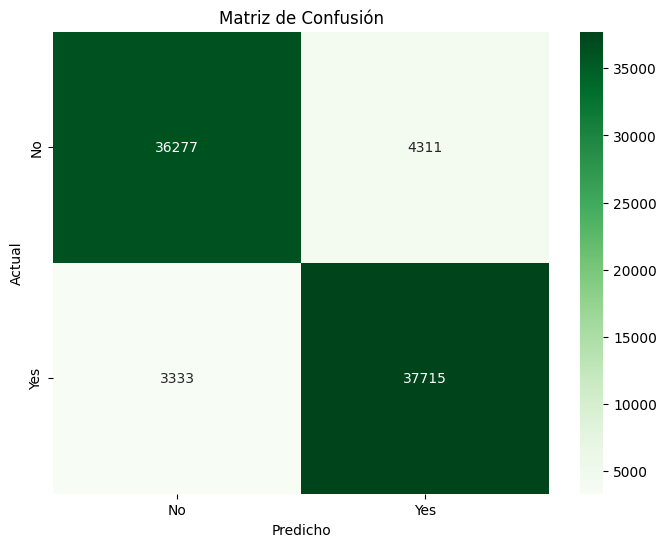

In [70]:
# Gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

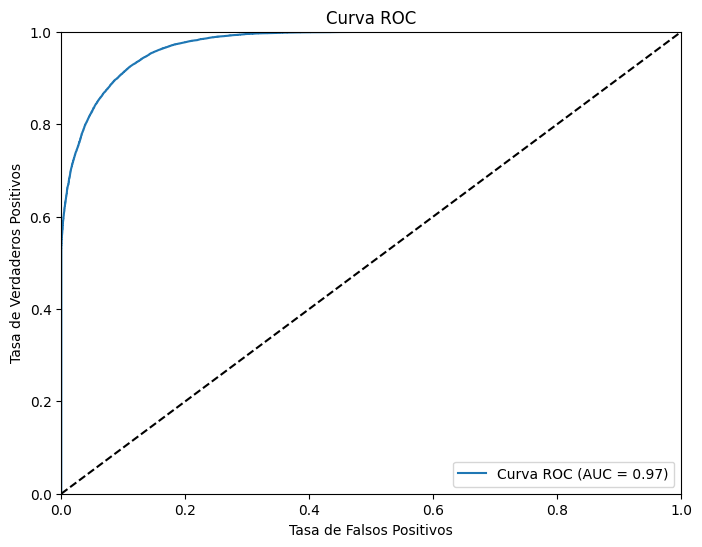

In [31]:
# Gráfico de la curva ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [36]:
df_last = df_full[df_full["pk_partition"] == "2019-05-28"]

In [41]:
df_last

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0
657986,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,Otros,1,02 - PARTICULARES,Más de 3 años,1
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0
1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0


In [42]:
df_customers_no_credit_card = df_last[df_last['target_credit_card'] == 0]


In [55]:
df_last['target_credit_card'].value_counts()

target_credit_card
0    434562
1      8433
Name: count, dtype: int64

In [54]:
df_customers_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años,0,0.304
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0.140
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años,0,0.130
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses,0,0.480
657147,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos mayores,"104,881.710",Madrid,KAT,0,02 - PARTICULARES,1-2 años,0,0.514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0.001
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0.001
1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0.071


In [43]:
# Obtener las características (X) de los clientes sin tarjeta de crédito
X_no_credit_card = df_customers_no_credit_card.drop(columns=['pk_partition', 'target_credit_card'])

In [44]:
X_no_credit_card

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"54,493.380",Lleida,Otros,1,02 - PARTICULARES,Más de 3 años
657817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,Otros,0,03 - UNIVERSITARIO,0-3 meses
657905,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,H,5,May,Longevos,"154,059.090",Madrid,KAT,1,01 - TOP,2-3 años
657336,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Adultos jóvenes,"108,223.410",Madrid,KAT,1,02 - PARTICULARES,0-3 meses
657147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos mayores,"104,881.710",Madrid,KAT,0,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años
1166764,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años
1166763,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años


In [45]:
# One-Hot Encoding para las variables categóricas
X_no_credit_card_ohe = pd.DataFrame(ohe.transform(X_no_credit_card[categorical_cols]), 
                                     columns=ohe.get_feature_names_out(categorical_cols), 
                                     index=X_no_credit_card.index)

In [46]:
# Escalar las variables numéricas
X_no_credit_card_scaled = pd.DataFrame(scaler.transform(X_no_credit_card[numerical_cols]), 
                                       columns=numerical_cols, 
                                       index=X_no_credit_card.index)

In [47]:
# Combinar las columnas procesadas
X_no_credit_card_processed = pd.concat([X_no_credit_card_scaled, X_no_credit_card_ohe], axis=1)

In [48]:
X_no_credit_card_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,mes_partition,median_salary,active_customer,gender_V,mes_nombre_partition_August,mes_nombre_partition_December,mes_nombre_partition_February,mes_nombre_partition_January,mes_nombre_partition_July,mes_nombre_partition_June,mes_nombre_partition_March,mes_nombre_partition_May,mes_nombre_partition_November,mes_nombre_partition_October,mes_nombre_partition_September,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,region_code_Asturias,region_code_Badajoz,"region_code_Baleares, Islas",...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.586,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
657817,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.500,-1.000,-1.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.441,-1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
657905,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.972,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
657336,0.000,0.000,0.000,0.0

In [49]:
# Predecir las probabilidades para los clientes sin tarjeta de crédito
probabilities_no_credit_card = xgb_model.predict_proba(X_no_credit_card_processed)[:, 1]

In [50]:
# Agregar las probabilidades al DataFrame original
df_customers_no_credit_card['probability'] = probabilities_no_credit_card

In [68]:
df_sorted = df_customers_no_credit_card.sort_values(by='probability', ascending=False)

In [69]:
df_sorted

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1395591,2019-05-28,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,V,5,May,Adultos,"69,864.420",Lleida,KHM,1,02 - PARTICULARES,1-2 años,0,0.998
1000488,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,V,5,May,Adultos jóvenes,"179,588.400","Baleares, Islas",KFC,1,02 - PARTICULARES,Más de 3 años,0,0.989
1126797,2019-05-28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,60,V,5,May,Adultos jóvenes,"70,302.540",Madrid,KAT,1,02 - PARTICULARES,2-3 años,0,0.988
1134925,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,V,5,May,Adultos jóvenes,"163,779.300","Baleares, Islas",KFC,1,02 - PARTICULARES,Más de 3 años,0,0.988
1111523,2019-05-28,0,0,0,1,0,1,0,1,1,1,1,1,0,0,7,1,4,1,3,0,0,40,120,0,V,5,May,Adultos,"133,505.820",Barcelona,KFC,1,02 - PARTICULARES,Más de 3 años,0,0.988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450287,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Jóvenes,"147,918.930",Lugo,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0.000
1442260,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,V,5,May,Jóvenes,"153,751.260",Lugo,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0.000
1487362,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,H,5,May,Jóvenes,"156,705.210",Ceuta,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0.000


In [51]:
# Seleccionar los 10,000 clientes sin tarjeta de crédito con mayor probabilidad de compra
top_customers_no_credit_card = df_customers_no_credit_card.nlargest(10000, 'probability')

In [53]:
top_customers_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,target_credit_card,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1395591,2019-05-28,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,V,5,May,Adultos,"69,864.420",Lleida,KHM,1,02 - PARTICULARES,1-2 años,0,0.998
1000488,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,V,5,May,Adultos jóvenes,"179,588.400","Baleares, Islas",KFC,1,02 - PARTICULARES,Más de 3 años,0,0.989
1126797,2019-05-28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,60,V,5,May,Adultos jóvenes,"70,302.540",Madrid,KAT,1,02 - PARTICULARES,2-3 años,0,0.988
1134925,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,V,5,May,Adultos jóvenes,"163,779.300","Baleares, Islas",KFC,1,02 - PARTICULARES,Más de 3 años,0,0.988
1111523,2019-05-28,0,0,0,1,0,1,0,1,1,1,1,1,0,0,7,1,4,1,3,0,0,40,120,0,V,5,May,Adultos,"133,505.820",Barcelona,KFC,1,02 - PARTICULARES,Más de 3 años,0,0.988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103581,2019-05-28,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,2,0,0,0,0,20,0,0,V,5,May,Adultos mayores,"159,456.060",Valencia,KFC,1,02 - PARTICULARES,Más de 3 años,0,0.791
1113683,2019-05-28,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,1,2,0,0,0,0,20,0,0,V,5,May,Adultos jóvenes,"63,137.700",Murcia,KHE,1,02 - PARTICULARES,Más de 3 años,0,0.791
1261616,2019-05-28,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,V,5,May,Adultos mayores,"87,362.670",Cantabria,KFC,1,02 - PARTICULARES,2-3 años,0,0.791
